In [2]:

import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mojzi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## stop words

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [11]:
data = document = open(os.path.join('abstracts_collection.txt'), encoding="utf-8").readlines()

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'investigate', 'various', 'contextual', 'effects', 'on', 'text', 'interpretation', 'and', 'account', 'for', 'them', 'by', 'providing', 'contextual', 'constraints', 'in', 'logical', 'theory', 'of', 'text', 'interpretation', 'on', 'the', 'basis', 'of', 'the', 'way', 'these', 'constraints', 'interact', 'with', 'the', 'other', 'knowledge', 'sources', 'we', 'draw', 'some', 'general', 'conclusions', 'about', 'the', 'role', 'of', 'domain', 'specific', 'information', 'top', 'down', 'and', 'bottom', 'up', 'discourse', 'information', 'flow', 'and', 'the', 'usefulness', 'of', 'formalisation', 'in', 'discourse', 'theory', 'introduct', 'ion', 'and', 'two', 'essential', 'parts', 'of', 'discourse', 'interpretation', 'involve', 'determining', 'the', 'rhetorical', 'role', 'each', 'sentence', 'plays', 'in', 'the', 'text', 'and', 'ii', 'determining', 'the', 'temporal', 'relations', 'between', 'the', 'events', 'described', 'preceding', 'discourse', 'context', 'has', 'significant', 'effects', 'on',

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['we', 'investigate', 'various', 'contextual', 'effects', 'on', 'text', 'interpretation', 'and', 'account', 'for', 'them', 'by', 'providing', 'contextual', 'constraints', 'in', 'logical', 'theory', 'of', 'text', 'interpretation', 'on', 'the', 'basis', 'of', 'the', 'way', 'these', 'constraints', 'interact', 'with', 'the', 'other', 'knowledge', 'sources', 'we', 'draw', 'some', 'general', 'conclusions', 'about', 'the', 'role', 'of', 'domain', 'specific', 'information', 'top_down', 'and', 'bottom_up', 'discourse', 'information', 'flow', 'and', 'the', 'usefulness', 'of', 'formalisation', 'in', 'discourse', 'theory', 'introduct', 'ion', 'and', 'two', 'essential', 'parts', 'of', 'discourse', 'interpretation', 'involve', 'determining', 'the', 'rhetorical', 'role', 'each', 'sentence', 'plays', 'in', 'the', 'text', 'and', 'ii', 'determining', 'the', 'temporal', 'relations', 'between', 'the', 'events', 'described', 'preceding', 'discourse', 'context', 'has', 'significant', 'effects', 'on', 'both'

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['investigate', 'various', 'contextual', 'effect', 'text', 'interpretation', 'account', 'provide', 'contextual', 'constraint', 'logical', 'theory', 'text', 'interpretation', 'basis', 'way', 'constraint', 'interact', 'knowledge', 'source', 'draw', 'general', 'conclusion', 'role', 'domain', 'specific', 'information', 'top', 'bottom', 'discourse', 'information', 'flow', 'usefulness', 'formalisation', 'discourse', 'theory', 'introduct', 'ion', 'essential', 'part', 'discourse', 'interpretation', 'involve', 'determine', 'rhetorical', 'role', 'sentence', 'play', 'text', 'determine', 'temporal', 'relation', 'event', 'describe', 'precede', 'discourse', 'context', 'significant', 'effect', 'aspect', 'interpretation', 'example', 'text', 'vacuo', 'may', 'non', 'iconic', 'explanation', 'pushing', 'cause', 'falling', 'explain', 'max', 'fall', 'pair', 'sentence', 'may', 'receive', 'iconic', 'narrative', 'interpretat', 'ion', 'discourse', 'context', 'provide', 'takes_advantage', 'max', 'vulnerability'

## Adding stop words

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(len(id2word))
# remove useless tokens
list_of_ids_to_remove = [id2word.token2id[tok] for tok in 'research,use,show,paper,model,base,result,method,approach,propose,problem,algorithm,present,datum,also,new,experiment,provide,work,good,demonstrate,improve,give,first,different,novel,achieve,however,many,well,introduce,art'.split(',')]
id2word.filter_tokens(list_of_ids_to_remove)
print(len(id2word))
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

24026
23994
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 3), (12, 1), (13, 1), (14, 1), (15, 2), (16, 3), (17, 2), (18, 1), (19, 2), (20, 5), (21, 1), (22, 1), (23, 1), (24, 3), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 2), (45, 1), (46, 1), (47, 4), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 7), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 1), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 2), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 5), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1)]]


In [17]:
i_f_tuples = list(id2word.dfs.items())

In [18]:
i_f_tuples_sorted = sorted(i_f_tuples, key=lambda x:x[1], reverse = True)


In [19]:
for i, f in i_f_tuples_sorted[:100]:
    print(id2word[i])

learn
task
system
set
performance
feature
information
language
state
word
large
machine
learning
structure
time
number
describe
analysis
technique
study
framework
domain
apply
make
training
text
function
exist
process
application
order
perform
compare
several
representation
find
semantic
outperform
high
dataset
develop
consider
evaluation
include
accuracy
space
simple
experimental
previous
classification
require
evaluate
combine
translation
sentence
efficient
knowledge
obtain
train
generate
allow
class
corpus
solve
natural
may
example
general
level
english
linear
non
important
test
network
address
statistical
multiple
standard
significantly
context
case
label
often
search
solution
distribution
human
represent
way
automatically
term
identify
focus
know
measure
inference
challenge
call
type


In [ ]:
# from gensim.models.wrappers import LdaMallet

In [31]:
os.environ.update({'MALLET_HOME':r'C:/Users/mojzi/OneDrive/Documents/Citacnisit/mallet-2.0.8/mallet-2.0.8/'})

## Add Mallet path

In [32]:
mallet_path = "C:/Users/mojzi/OneDrive/Documents/Citacnisit/mallet-2.0.8/mallet-2.0.8/bin/mallet.bat" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=24, id2word=id2word)

In [33]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('domain', 0.09503439917299397),
   ('task', 0.059351940968880336),
   ('learn', 0.052400812747299755),
   ('knowledge', 0.04277617367126511),
   ('target', 0.026842048978718853),
   ('specific', 0.02595087869390083),
   ('source', 0.0224931379888069),
   ('framework', 0.016041065126724416),
   ('address', 0.015042954407728229),
   ('transfer', 0.014757779916586462)]),
 (20,
  [('state', 0.07674958993985785),
   ('learn', 0.05094997266265719),
   ('action', 0.03864816839803171),
   ('policy', 0.03143794423182067),
   ('learning', 0.024637780207763804),
   ('space', 0.02033214871514489),
   ('function', 0.02029797703663204),
   ('control', 0.016402405686167305),
   ('reinforcement', 0.015274740295243302),
   ('optimal', 0.014693821760524877)]),
 (18,
  [('structure', 0.06251814223512336),
   ('graph', 0.05152394775036284),
   ('network', 0.04013062409288824),
   ('group', 0.019593613933236574),
   ('apply', 0.015747460087082728),
   ('attribute', 0.015711175616835993),
   ('mat

In [34]:
from gensim.models.ldamodel import LdaModel
import numpy

def ldaMalletConvertToldaGen(mallet_model):
    model_gensim = LdaModel(
    id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
    alpha=mallet_model.alpha, eta=0, iterations=1000,
    gamma_threshold=0.001,
    dtype=numpy.float32
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [35]:
# transform the mallet Lda model to gensim Lda model
gensim_model = ldaMalletConvertToldaGen(ldamallet)

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(gensim_model, corpus, id2word)
vis

C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\mojzi\AppData\Local\Continuum\anaconda3\envs\myenv1\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=Tru

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
23    -0.066095  0.155823       1        1  4.385324
8     -0.069807  0.138503       2        1  4.344603
1     -0.218656  0.085338       3        1  4.320305
10     0.235771  0.102097       4        1  4.312594
12    -0.162230  0.037420       5        1  4.309284
4     -0.061856 -0.059062       6        1  4.284693
19    -0.154625  0.090244       7        1  4.253212
20    -0.166943 -0.066867       8        1  4.246073
3      0.067232  0.134597       9        1  4.242071
6     -0.170459 -0.074841      10        1  4.228246
11    -0.179774  0.013326      11        1  4.208722
9      0.072818  0.110082      12        1  4.191321
0      0.169608  0.079657      13        1  4.139112
2      0.201077 -0.037484      14        1  4.127852
5      0.038720 -0.278332      15        1  4.115705
22     0.160019  0.085854      16        1  4.099552
7     -0.133476  0.081770      17        1  4.083654
14     0.057865 -0.092422      18        1  4.060367
15     0.007621 -0.002714      19        1  4.058566
18    -0.032498 -0.079666      20        1  4.051726
16     0.186818  0.015018      21        1  4.046391
13     0.045755 -0.185732      22        1  4.031769
17     0.008933 -0.285111      23        1  3.962192
21     0.164183  0.032500      24        1  3.896667, topic_info=     Category         Freq            Term        Total  loglift  logprob
302   Default  6085.000000          system  6085.000000  30.0000  30.0000
383   Default  4821.000000         feature  4821.000000  29.0000  29.0000
165   Default  5879.000000            task  5879.000000  28.0000  28.0000
449   Default  4487.000000            word  4487.000000  27.0000  27.0000
120   Default  6941.000000           learn  6941.000000  26.0000  26.0000
44    Default  3716.000000     information  3716.000000  25.0000  25.0000
304   Default  2931.000000     translation  2931.000000  24.0000  24.0000
156   Default  4095.000000        language  4095.000000  23.0000  23.0000
21    Default  3009.000000          domain  3009.000000  22.0000  22.0000
353   Default  3357.000000           state  3357.000000  21.0000  21.0000
733   Default  2451.000000  representation  2451.000000  20.0000  20.0000
384   Default  2741.000000        function  2741.000000  19.0000  19.0000
276   Default  2783.000000       structure  2783.000000  18.0000  18.0000
274   Default  4400.000000             set  4400.000000  17.0000  17.0000
430   Default  1951.000000           label  1951.000000  16.0000  16.0000
559   Default  1971.000000          search  1971.000000  15.0000  15.0000
182   Default  2359.000000           large  2359.000000  14.0000  14.0000
370   Default  1879.000000  classification  1879.000000  13.0000  13.0000
787   Default  1876.000000           agent  1876.000000  12.0000  12.0000
85    Default  2630.000000            text  2630.000000  11.0000  11.0000
205   Default  2667.000000            time  2667.000000  10.0000  10.0000
70    Default  1714.000000        relation  1714.000000   9.0000   9.0000
162   Default  2647.000000        semantic  2647.000000   8.0000   8.0000
360   Default  2163.000000        training  2163.000000   7.0000   7.0000
435   Default  2081.000000         network  2081.000000   6.0000   6.0000
431   Default  2721.000000        learning  2721.000000   5.0000   5.0000
293   Default  2309.000000         machine  2309.000000   4.0000   4.0000
579   Default  1650.000000            user  1650.000000   3.0000   3.0000
127   Default  3286.000000     performance  3286.000000   2.0000   2.0000
114   Default  1555.000000           graph  1555.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
302   Topic24  5387.689453          system  6085.095215   3.1233  -1.6842
1782  Topic24   139.829926      submission   147.719086   3.1902  -5.3357
1454  Topic24   124.999481           chunk   134.278061   3.173

In [37]:
type(data)

list

In [38]:
data[1]

'The Canadian Traveller problem is a stochastic shortest paths problem in which one learns the cost of an edge only when arriving at one of its endpoints. The goal is to find an optimal policy that minimizes the expected cost of travel. The problem is known to be #P-hard. Since there has been no significant progress on approximation algorithms for several decades, we have chosen to seek out special cases for which exact solutions exist, in the hope of demonstrating techniques that could lead to further progress. Applying a mix of techniques from algorithm analysis and the theory of Markov Decision Processes, we provide efficient exact algorithms for directed acyclic graphs and (undirected) graphs of disjoint paths from source to destination with random two-valued edge costs. We also give worst-case performance analysis and experimental data for two natural heuristics.\n'

In [39]:
type(corpus)

list

In [40]:
corpus[1]

[(3, 1),
 (24, 2),
 (79, 1),
 (80, 1),
 (87, 1),
 (94, 2),
 (95, 1),
 (96, 1),
 (97, 1),
 (98, 1),
 (99, 3),
 (100, 1),
 (101, 1),
 (102, 1),
 (103, 1),
 (104, 1),
 (105, 1),
 (106, 1),
 (107, 1),
 (108, 2),
 (109, 1),
 (110, 1),
 (111, 1),
 (112, 1),
 (113, 1),
 (114, 2),
 (115, 1),
 (116, 1),
 (117, 1),
 (118, 1),
 (119, 1),
 (120, 1),
 (121, 1),
 (122, 1),
 (123, 1),
 (124, 1),
 (125, 1),
 (126, 1),
 (127, 1),
 (128, 1),
 (129, 1),
 (130, 2),
 (131, 1),
 (132, 1),
 (133, 1),
 (134, 1),
 (135, 1),
 (136, 1),
 (137, 1),
 (138, 2),
 (139, 1),
 (140, 1),
 (141, 1),
 (142, 1),
 (143, 1)]

In [45]:
#doc_topics, word_topics, phi_values = gensim_model.get_document_topics(corpus[1], per_word_topics=True)

In [46]:
doc_topics

[(0, 0.14305922),
 (1, 0.06578489),
 (2, 0.016176166),
 (3, 0.013904055),
 (4, 0.017626738),
 (5, 0.012042623),
 (6, 0.01524792),
 (7, 0.014612019),
 (8, 0.04280044),
 (9, 0.030001422),
 (10, 0.018014723),
 (11, 0.0140669625),
 (12, 0.036856744),
 (13, 0.015683932),
 (14, 0.047358662),
 (15, 0.042753726),
 (16, 0.048451424),
 (17, 0.012515043),
 (18, 0.052079927),
 (19, 0.0130859),
 (20, 0.015890563),
 (21, 0.019825831),
 (22, 0.09635415),
 (23, 0.1958069)]

In [47]:
topics_of_abstracts = []
for abstract_bow in corpus:
    doc_topics, word_topics, phi_values = gensim_model.get_document_topics(abstract_bow, per_word_topics=True)
    topics_of_abstracts.append(doc_topics)

In [49]:
len(topics_of_abstracts)

10975

In [64]:
data[11]

'In this paper we present a novel online transfer learning approach to determine the set of tests to perform, and the sequence in which they need to be performed, in order to develop an accurate diagnosis while minimizing the cost of performing the tests. Our learning approach can be incorporated as part of a clinical decision support system (CDSS) with which clinicians can interact. The approach builds on a contextual bandit framework and uses online transfer learning to overcome limitations with the availability of rich training data sets that capture different conditions, context, test results as well as outcomes. We provide confidence bounds for our recommended policies, which is essential in order to build the trust of clinicians. We evaluate the algorithm against different transfer learning approaches on real-world patient alarm datasets collected from Neurological Intensive Care Units (with reduced costs by 20%).\n'

In [54]:
import json

In [55]:
with open('data_connected_graph.jsonl') as f:
    a = []
    for line in f.readlines():
        dic = json.loads(line)
        a.append(dic)

In [87]:
a[1]["id"]

'478dac375b3dc60be161e2fb5091ac44a247a48a'

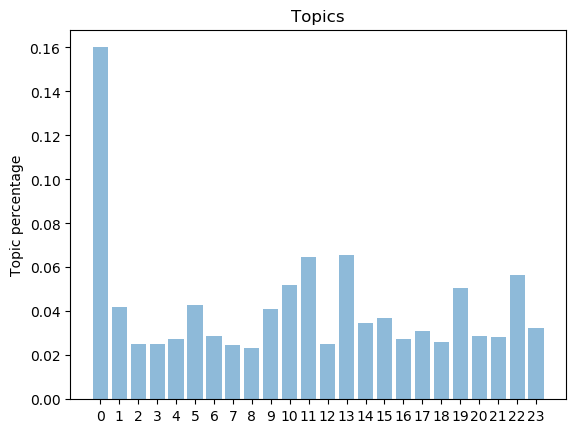

In [81]:
plt.bar(*zip(*topics_of_abstracts[1000]), align='center', alpha=0.5)
plt.ylabel('Topic percentage')
plt.title('Topics')
plt.xticks(np.arange(24))
plt.show()

In [82]:
data[1000]

'We consider the problem of learning context-dependent mappings from sentences to logical form. The training examples are sequences of sentences annotated with lambda-calculus meaning representations. We develop an algorithm that maintains explicit, lambda-calculus representations of salient discourse entities and uses a context-dependent analysis pipeline to recover logical forms. The method uses a hidden-variable variant of the perception algorithm to learn a linear model used to select the best analysis. Experiments on context-dependent utterances from the ATIS corpus show that the method recovers fully correct logical forms with 83.7% accuracy.\n'

In [83]:
gensim_model.print_topic(0, topn=15)

'0.048*"tree" + 0.043*"semantic" + 0.040*"parse" + 0.040*"dependency" + 0.031*"syntactic" + 0.030*"parser" + 0.029*"structure" + 0.023*"grammar" + 0.023*"sentence" + 0.021*"annotation" + 0.018*"discourse" + 0.015*"argument" + 0.010*"language" + 0.010*"rule" + 0.009*"natural"'

In [80]:
gensim_model.print_topic(22, topn=15)

'0.103*"information" + 0.056*"relation" + 0.038*"extract" + 0.036*"type" + 0.033*"extraction" + 0.030*"text" + 0.028*"pattern" + 0.025*"entity" + 0.024*"context" + 0.024*"semantic" + 0.017*"web" + 0.017*"link" + 0.015*"identify" + 0.014*"automatically" + 0.013*"knowledge"'

In [88]:
id_and_topic = {}
for i in range(len(a)):
    id_and_topic.update({a[i]["id"] : topics_of_abstracts[i]})

In [91]:
id_and_topic

{'5cdac93dc6d1e08e76d647ff9b50fce62d714190': [(0, 0.14305893),
  (1, 0.06578427),
  (2, 0.01617603),
  (3, 0.013904071),
  (4, 0.017626842),
  (5, 0.012042623),
  (6, 0.0152478395),
  (7, 0.014611957),
  (8, 0.042798653),
  (9, 0.030003985),
  (10, 0.018012775),
  (11, 0.014066911),
  (12, 0.03685725),
  (13, 0.015683731),
  (14, 0.047358442),
  (15, 0.042754494),
  (16, 0.04845037),
  (17, 0.012515036),
  (18, 0.052080397),
  (19, 0.013085888),
  (20, 0.015890593),
  (21, 0.019825855),
  (22, 0.09635624),
  (23, 0.1958068)],
 '478dac375b3dc60be161e2fb5091ac44a247a48a': [(0, 0.033296805),
  (1, 0.059580553),
  (2, 0.032301437),
  (3, 0.022734508),
  (4, 0.060573984),
  (5, 0.025502112),
  (6, 0.039170776),
  (7, 0.024819707),
  (8, 0.06376832),
  (9, 0.021738207),
  (10, 0.020555176),
  (11, 0.039274573),
  (12, 0.13899985),
  (13, 0.022770219),
  (14, 0.034778558),
  (15, 0.0270288),
  (16, 0.01964738),
  (17, 0.032230686),
  (18, 0.089475945),
  (19, 0.05646182),
  (20, 0.056792352),

In [92]:
gensim_model.save("ldamallet_abstracts.model")

In [94]:
import pickle

In [95]:
with open('id_and_topic.pickle', 'wb') as handle:
    pickle.dump(id_and_topic, handle, protocol=pickle.HIGHEST_PROTOCOL)